# Introdução

Esse notebook tem objetivo de entender os princípios de estimações de pontuação de crédito bancário.  O crédito faz parte da vida de muitas pessoas mas para fornecer esse tipo de serviço é necessário entender os riscos envolvidos em emprestimos pessoais e consignados, cartões de credito, financiamento de imóveis e veículos, apesar de todos esses exemplo, pouco se fala sobre como funciona a tomada de decisão por trás do sistema de crédito. 

> [Credit Scoring Google Scholar](https://scholar.google.com.br/scholar?hl=pt-PT&as_sdt=0%2C5&as_vis=1&q=credit+scoring&btnG=)


## Cadeia de crédito

<img src='https://raw.githubusercontent.com/ConradBitt/Credit_Scoring/main/images/ciclo_credito.png'  width=50%>

Os pilares da cadeia de crédito consiste em ciclo de quatro etapas que fundamentam o funcionamento do sistema, eles são 

* Prospecção 

* Concessão 

* Gestão de Risco 

* Recuperação 


Neste notebook vou focar em quais métricas de avaliação são  utilizadas na etapa de **concessão**. 

Um ponto importante na cadeia de crédito são os grupos de clientes, eles se dividem em dois **poupadores** e **tomadores**. Os poupadores são clientes que reservam suas economias para extrair rendimentos no futuro e os tomadores são clientes que tomam emprestado uma quantia hoje para pagar no futuro. Quem faz a intermediação entre popuadores e tomadores são as instituições financeiras. (*Lembrando que apenas instituições podem fazer essa mediação, pessoas físicas emprestando valores monetarios a troco de juros pode caracterizar o crime de agiotagem.*)

## Pedido de crédito 

<img src='https://raw.githubusercontent.com/ConradBitt/Credit_Scoring/main/images/pedido_credito.png'>

O pedido de credito se inicia com o **tomador** indo até uma **instituição financeira** e ela através de um **modelo de decisão** e este modelo irá dizer se o **tomador** terá um credito **aprovado** ou **rejeitado**. 

## Credit Scoring

O Credit Scoring consiste em analisar a probabilidade (0 ou 1) de um evento ocorrer dado um conjunto de variáveis aleatórias a respeito dos fenômenos envolvidos. Agora pensando na concessão o tipo de evento que se busca estimar é se um tomador de crédito será inadimplente ou não, ou seja, **é um problema de classificação binária**.

Basicamente toda análise de concessão de crédito consiste em analisar o risco de uma operação, por parte da instituição financeira, o risco é medido **como a expectativa de receber um montante em um determinado período de tempo não ocorrer**. Esse risco é incluido de forma parcelada através dos juros cobrados ao tomador do credito..



# Importações de módulos python

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl
import sklearn


from matplotlib import pyplot as plt

In [2]:
print('~~ Versão Python ~~')
!python --version

print('\n\n~~ Versões Módulos ~~')

print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'matplotlib: {mpl.__version__}')
print(f'sklearn: {sklearn.__version__}')

~~ Versão Python ~~
Python 3.7.9


~~ Versões Módulos ~~
numpy: 1.20.1
pandas: 1.2.4
seaborn: 0.11.1
matplotlib: 3.3.4
sklearn: 0.24.1


**Definindo semente**

```python 
>>> np.random.randint(0,(2**32) - 1)
2427933764
```

In [3]:
semente = 2427933764

# Base de dados

Os dados que serão utilizados neste trabalho são da UCI Machine Learning Repository, mais precisamente o German Credit Data, disponível em: 

> https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

In [4]:
credit_score = pd.read_csv('./dados/german_credit.csv', header=0)

In [5]:
display(credit_score.info())
display(credit_score.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   personal_status_sex         1000 non-null   object
 10  other_debtors               1000 non-null   object
 11  present_res_since           1000 non-null   int64 
 12  property                    1000 non-null   object
 13  age                         1000 non-null   int64

None

(1000, 21)

> Através das informações desse dataset podemos verificar que são 1000 observações dividida 21 variáveis, oito do tipo `int` e treze variáveis do tipo `object`.

In [6]:
informacoes_duplicadas = credit_score.duplicated()
credit_score[informacoes_duplicadas]

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker


> Podemos verificar acima que não se tem nenhuma informação duplicada

In [7]:
valores_nulos = credit_score.isnull().sum()
valores_nulos

default                       0
account_check_status          0
duration_in_month             0
credit_history                0
purpose                       0
credit_amount                 0
savings                       0
present_emp_since             0
installment_as_income_perc    0
personal_status_sex           0
other_debtors                 0
present_res_since             0
property                      0
age                           0
other_installment_plans       0
housing                       0
credits_this_bank             0
job                           0
people_under_maintenance      0
telephone                     0
foreign_worker                0
dtype: int64

> Como já se confirmava no método `.info()` podemos verificar que não tem nenhuma variável com valores nulos.

# Credit Scoring 

O Credit Scoring é um modelo estatististico **multivariado** utilizado para estimar a probabilidade de um tomador de credito ser inadimplente ou não. Geralmente estamos acostumado a pedir uma análise de credito à um banco, mas neste trabalho estamos fazendo o papel da instituição financeira, avaliando se devemos aprovar ou não uma solicitação.

Na perspectiva de uma instituição financeira precisamos dos dados do tomador de crédito, que basicamente são informações cadastrais e financeiras, a partir dessas informações aplica-se num modelo de **credit scoring** que é responsável pelo calculo da probabilidade de recomendar ou rejeitar o fornecimento de crédito ao cliente (tomador).

O trabalho de um modelo de credit scoring consiste basicamente em uma classificação, classificar tomadores de credito em bom pagadores ou não. Dito isso, tem-se em mente existem alguns estimadores que podem fornecer soluções para esses problema, por exemplo:

* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression)

* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier)

* [Naive Bayes](https://scikit-learn.org/stable/modules/classes.html?highlight=naive#module-sklearn.naive_bayes)

* [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/classes.html?highlight=naive#module-sklearn.svm)

Esses são alguns modelos utilizados para auxiliar na estimação de probabilidades de classificações, mas neste trabalho vou utilizar a Regressão Logística ou Logistic Regression. A regressão logistica é um modelo amplamente utilizada não só em análise de concessão de credito, mas também além da área financeira, como por exemplo área médica, automotiva, segurança, etc. Este estimador é de fácil auditoria, facil de compreender os processos realizados por ele, também é um estimador rapido, facilitando a aplicação em um grande volume de dados.

# Logistic Regression 

Uma das condições para aplicabilidade da regressão logsitica é que exista uma variável **dependente** e **binária**, que possa ser estimada por **variáveis independentes** de valores conhecidos sejam elas de natureza quantitativa ou qualitativa. Na base de dados que vamos utilizar a variável dependente é indicada pelo rótulo **default** e as demais variáveis são categoricas e discretas.

Vou exibir os dados de forma transposta para que possamos ler as variáveis:

In [8]:
credit_score.head().T

,0,1,2,3,4
default,0,1,0,0,1
account_check_status,< 0 DM,0 <= ... < 200 DM,no checking account,< 0 DM,< 0 DM
duration_in_month,6,48,12,42,24
credit_history,critical account/ other credits existing (not ...,existing credits paid back duly till now,critical account/ other credits existing (not ...,existing credits paid back duly till now,delay in paying off in the past
purpose,domestic appliances,domestic appliances,(vacation - does not exist?),radio/television,car (new)
credit_amount,1169,5951,2096,7882,4870
savings,unknown/ no savings account,... < 100 DM,... < 100 DM,... < 100 DM,... < 100 DM
present_emp_since,.. >= 7 years,1 <= ... < 4 years,4 <= ... < 7 years,4 <= ... < 7 years,1 <= ... < 4 years
installment_as_income_perc,4,2,2,2,3
personal_status_sex,male : single,female : divorced/separated/married,male : single,male : single,male : single


> Podemos ver na primeira linha que a variável `default` é binária. As demais são divididas entre categoricas, note por exemplo, a variável `account_check_status` que é basicamente um status da conta corrente é uma variável categorica com valores do tipo `< 0`, `0 <= ... < 200 DM` ou `no checking account`. Já a variável `credit_amount` é uma variável que indica o valor de emprestimo, isto é, um valor quantitativo discreto.

## Separação de variáveis dependentes e independentes

Dado que definimos a variável dependente `Default` e as independentes, podemos separar os dados a fim de transformar em algo similar à um problema matemático do tipo: 

$$y = f(x),$$

onde $y$ é a variável dependente, $x$ a variável independente e $f$ um modelo aplicado para estimar o valor de $y$.

In [9]:
y = credit_score['default']

In [10]:
x = credit_score.drop('default', axis='columns')

Agora temos as duas variáveis da modelagem:

In [11]:
x.shape, y.shape

((1000, 20), (1000,))

Vamos ver a distribuição dos targets a fim de verificar se não está mal distribuido:

In [12]:
y.value_counts()

0    700
1    300
Name: default, dtype: int64

> Note que **a distribuição dos rótulos `0` e `1` não é equivalente**, em muitos casos quando modelos são treinados com dados desproporcionais **pode acontecer de criar um viés** principalmente se a métrica de avaliação (acurácia e precisão, por exemplo) utilizada depende da quantidade de elementos em cada grupo.

Existem muitos casos onde não conseguimos contornar o problema que é trabalhar com bases desbalanceadas. Isso pode acontecer por vários fatores, desde a forma de coletar os dados e até mesmo características do problema aa ser resolvido. A diferença de amostras em determinadas classes podem afetar modelos de classificação.

Um dos problemas que podem ser ocasionados por desbalanceamento de classes é na utilização da acurácia. Se tivermos 80% de exemplo de clientes que não tiveram a concessão do crédito e 20% que obtiveram crédito podemos ter uma acurácia de 80%. Entretanto, o modelo pode estar acertando 80% das vezes simplesmente por "percebeu" que escolhendo a classe 1 100% das vezes acertará 80%... 

Para lidar com esse tipo de viés e tentar identificar este problema recomenda-se utilizar mais de uma métrica, por exemplo a f1-score, a precisão ou a sensiblidade, até mesmo uma mescla das duas através da curva ROC.

Outra estrategia é a reamostragem dos dados. Caso a base de dados seja grande o suficiente é possível dividi-la desconsiderando os exemplos em excesso de uma classe. Em alguns casos também é possível testar a sobreamostragem. Na sobreamostragem são adicionadas cópias de exemplo da classe que esta pouco representada na base de dados. Ainda em relação aos dados é possível gerar exemplo sintéticos. Para esse objetivo existem algorítmos que realizam uma amostragem randômica dos atributos dos exemplos da classe pouco representada, mas isso deve ser usado com cuidado, pois gerar dados aleatórios pode distorcer as informações do problema.

---

Note que temos muitos valores do tipo `object` nas variáveis independentes, precisamos transformar estas variaveis em quantitativas informações

In [13]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   account_check_status        1000 non-null   object
 1   duration_in_month           1000 non-null   int64 
 2   credit_history              1000 non-null   object
 3   purpose                     1000 non-null   object
 4   credit_amount               1000 non-null   int64 
 5   savings                     1000 non-null   object
 6   present_emp_since           1000 non-null   object
 7   installment_as_income_perc  1000 non-null   int64 
 8   personal_status_sex         1000 non-null   object
 9   other_debtors               1000 non-null   object
 10  present_res_since           1000 non-null   int64 
 11  property                    1000 non-null   object
 12  age                         1000 non-null   int64 
 13  other_installment_plans     1000 non-null   objec

Primeiro vamos selecionar todas as variáveis do tipo object

In [14]:
variaveis_object = x.select_dtypes(object).columns

x[variaveis_object].head(2)

,account_check_status,credit_history,purpose,savings,present_emp_since,personal_status_sex,other_debtors,property,other_installment_plans,housing,job,telephone,foreign_worker
0,< 0 DM,critical account/ other credits existing (not ...,domestic appliances,unknown/ no savings account,.. >= 7 years,male : single,none,real estate,none,own,skilled employee / official,"yes, registered under the customers name",yes
1,0 <= ... < 200 DM,existing credits paid back duly till now,domestic appliances,... < 100 DM,1 <= ... < 4 years,female : divorced/separated/married,none,real estate,none,own,skilled employee / official,none,yes


A primeira variável que vamos analisar é a `account_check_status`, vamos ver quais são seus possíveis valores:

In [15]:
x[variaveis_object[0]].unique()

array(['< 0 DM', '0 <= ... < 200 DM', 'no checking account',
       '>= 200 DM / salary assignments for at least 1 year'], dtype=object)

Agora precisamos remapear estas categorias para valores numéricos.

```python
>>> mapa_account_check_status = {
        'no checking account':0,
        '< 0 DM' : 1,
        '0 <= ... < 200 DM': 2,
        '>= 200 DM / salary assignments for at least 1 year': 3
    }

>>> x['account_check_status'] = x['account_check_status'].map(mapa_account_check_status)
>>> x['account_check_status'].head()

0    1
1    2
2    0
3    1
4    1
```

Para remapear os valores desta variáveis utilizamos o método `.map`

Podemos verificar acima que não temos mais as strings na categoria e o tipo da Séries mudou para `int64`. A proxima variável é a `credit_history`:

In [16]:
x[variaveis_object[1]].unique()

array(['critical account/ other credits existing (not at this bank)',
       'existing credits paid back duly till now',
       'delay in paying off in the past',
       'no credits taken/ all credits paid back duly',
       'all credits at this bank paid back duly'], dtype=object)

Farei este processo para todas as variáveis:

In [17]:
mapas = {}
for variavel in variaveis_object:
    rotulo = x[variavel].unique()
    
    # cria o mapa para a variável
    mapa = {}
    for indice, rotulo in enumerate(rotulo):
        mapa[rotulo] = indice
    
    mapas[f'mapa_{variavel}'] = mapa
    x[variavel] = x[variavel].map(mapa)

In [18]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   account_check_status        1000 non-null   int64
 1   duration_in_month           1000 non-null   int64
 2   credit_history              1000 non-null   int64
 3   purpose                     1000 non-null   int64
 4   credit_amount               1000 non-null   int64
 5   savings                     1000 non-null   int64
 6   present_emp_since           1000 non-null   int64
 7   installment_as_income_perc  1000 non-null   int64
 8   personal_status_sex         1000 non-null   int64
 9   other_debtors               1000 non-null   int64
 10  present_res_since           1000 non-null   int64
 11  property                    1000 non-null   int64
 12  age                         1000 non-null   int64
 13  other_installment_plans     1000 non-null   int64
 14  housing  

Note agra que todas as variáveis são do tipo `int`. Para consultar a conversao basta procurar a variável no dicionario `mapas` através da chave com o nome da variável com prefixo `mapa`, ex:

In [19]:
mapas['mapa_job']

{'skilled employee / official': 0,
 'unskilled - resident': 1,
 'management/ self-employed/ highly qualified employee/ officer': 2,
 'unemployed/ unskilled - non-resident': 3}

**Podemos ver como estão distribuidos os dados desta categoria**:

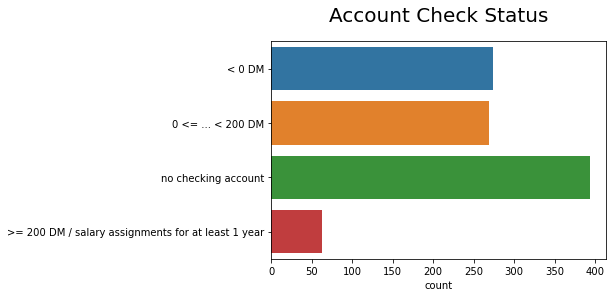

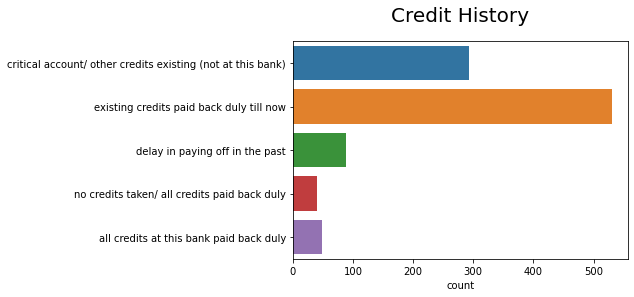

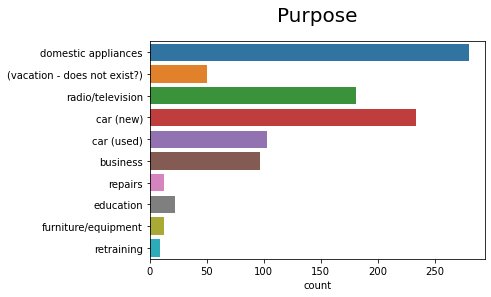

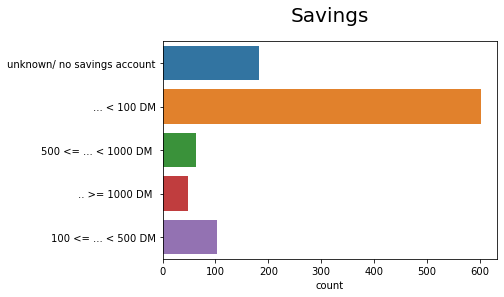

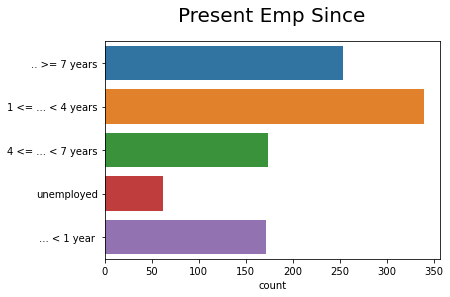

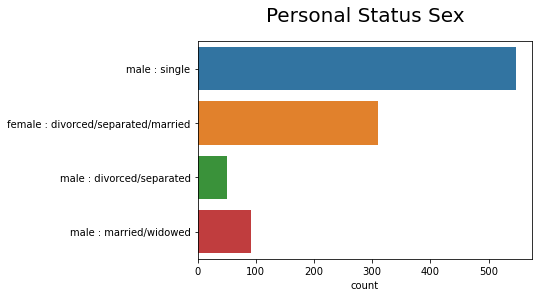

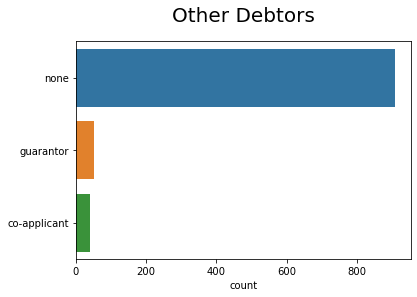

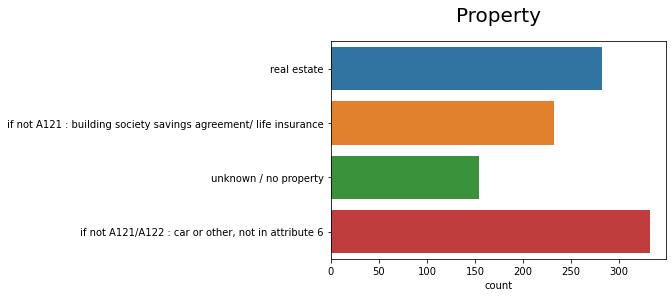

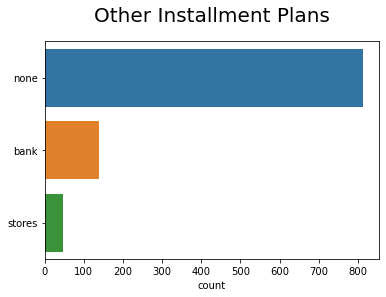

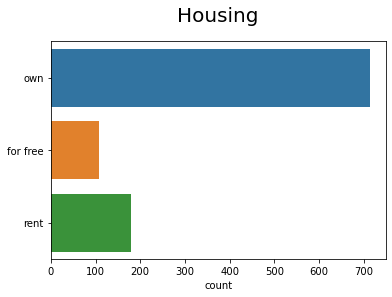

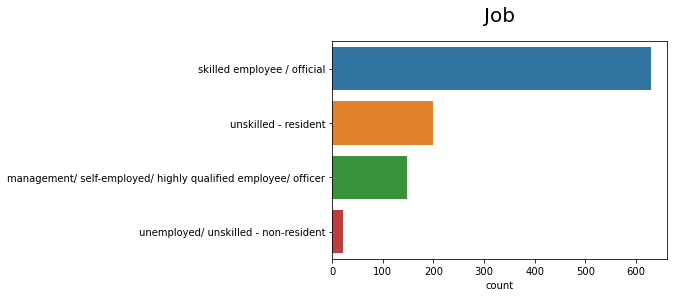

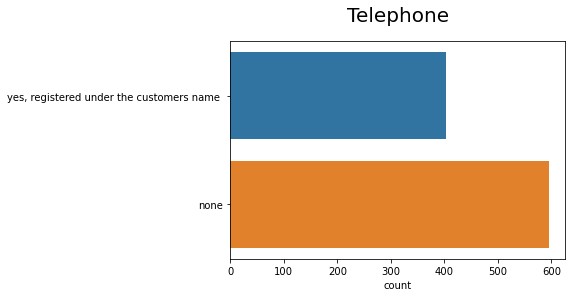

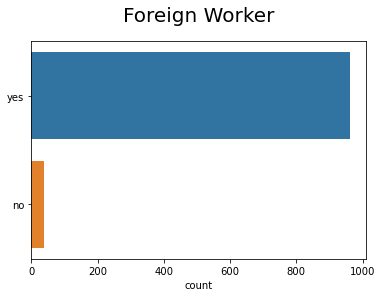

In [20]:
for variavel in variaveis_object:
    #plt.figure()    
    ax = sns.countplot(y = variavel, data = x)
    plt.yticks(x[variavel].unique(),
               labels=mapas[f'mapa_{variavel}'].keys())
    plt.title(variavel.replace('_',' ').title(), fontsize=20,pad=20)
    ax.set_ylabel('')
    plt.show()

É importante analisar se as variáveis não criaram algum tipo de correlação entre elas:

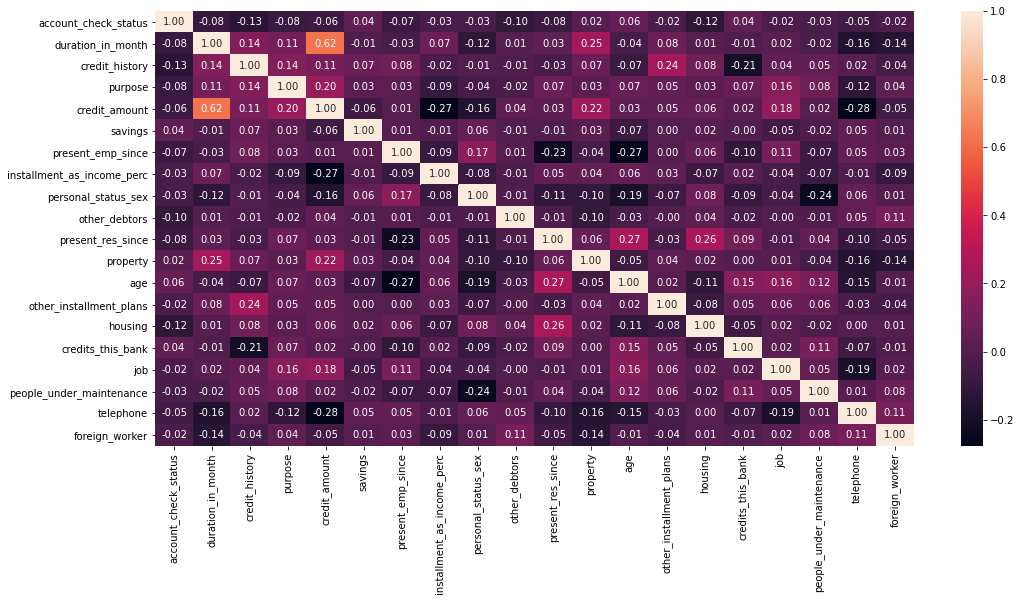

In [21]:
plt.figure(figsize=(17,8))
ax = sns.heatmap(x.corr(), annot=True, fmt='.2f')
ax;

> O mapa de correlação indica a correlação entre as variáveis, isto é, compara a correlação entre a variável da linha com a da coluna. Note que a correlação indicada na diagonal principal é sempre a maior possível pois indica a correlação da variável com ela mesma. Geralmente correlação acima de 0.7 indica uma forte correlação, o que não acontece com essas variáveis, então podemos dizer que são independentes até certo ponto.

pra garantir que as variáveis são independentes podemos utilizar alguns testes estatisticos, primeiro vamos verificar se alguma variável tem distribuição normal:

In [22]:
from scipy.stats import normaltest

In [23]:
statistica_norm, pvalor_norm = normaltest(x)
alpha = 5e-2
print('H0: Variável se distribui normalmente')
print('\t*True: Rejeita-se hipótese nula')
print('\t*False: Não tem evidência para rejeitar a hipótese nula')

pvalor_norm < alpha

H0: Variável se distribui normalmente
	*True: Rejeita-se hipótese nula
	*False: Não tem evidência para rejeitar a hipótese nula


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Ou seja, as variáveis, pelo teste de normalidade não se distribuem normalmente, então precisamos verificar se as combinações delas provém de uma mesma distribuição, para isso utilizarei o teste não paramétrico de Wilcoxon.

In [24]:
from scipy.stats import wilcoxon

In [25]:
def aplica_teste_wilcoxon(dataframe, exibe_mapa=False):
    """
    recebe um dataframe onde as colunas são as variáveis
    sera aplicado um teste de Wilcoxon-Mann-Whitney aos pares
    Retorno: dataframe e exibe um heatmap
    
    """
    variaveis = dataframe.columns 
    
    teste_U_wilcoxon = pd.DataFrame({}, columns = variaveis, index=variaveis)
    
    for variavel_i in variaveis:
        for variavel_j in variaveis:
            
            _, pvalor = wilcoxon(dataframe[variavel_i], dataframe[variavel_j],
                                zero_method='zsplit', mode='approx', correction=True)
            
            teste_U_wilcoxon.loc[variavel_i, variavel_j] = pvalor
    
    teste_U_wilcoxon = teste_U_wilcoxon.astype('float')
    
    if exibe_mapa:
        plt.figure(figsize=(15,8))
        ax = sns.heatmap(teste_U_wilcoxon, cmap='hot',
                         annot=True,fmt='.2f',
                         cbar_kws={'label':'$p-valor$'})
        plt.title('Mapa Teste $U$ de Wilcoxon-Mann-Whitey', fontsize=20, pad=20)
        
        return teste_U_wilcoxon, ax
    
    return teste_U_wilcoxon


O teste U de Wilcoxon-Mann-Whitney, testa se duas distribuições de variáveis provém de uma mesma distribuição. Ou seja, em função das hipóteses, temos que:

> $H_0$: $X \sim D(\mu, \sigma^2) = Y \sim D(\mu, \sigma^2)$, variáveis $X$ e $Y$, porém da mesma distribuição $D$

> $H_1$: $X \sim D(\mu, \sigma^2) \ne Y \sim D(\mu, \sigma^2)$, variáveis $X$ e $Y$, **NÃO** porém da mesma distribuição $D$

Lembrando que **rejeita-se $H_0$ se o** $p$-valor $\le 0.05$.

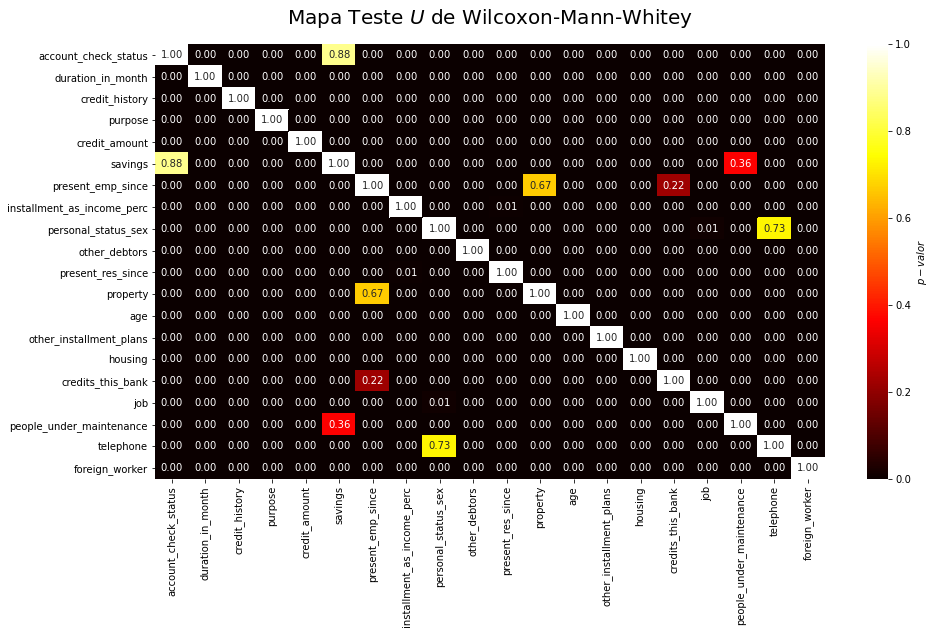

In [26]:
mapa_correlacao_wilcoxon, ax_mapa_wilcoxon = aplica_teste_wilcoxon(x, exibe_mapa=True)

Acima podemos ver nos quadradinhos mais escuros quais são as variáveis que provém de distribuições estatisticas diferentes, já as que estão com cores tendendo à tonalidades mais claras não se tem evidência estatistica para afirmar que estas variáveis provém de distribuições diferentes 

As variáveis que das mesmas distribuições são: 

* `savings` e `account_check_status`: poupança e status de verificação de conta 

* `property` e `present_emp_since`: propriedade e empregado desde

* `people_under_maintenance` e `savings` : pessoa sustentada e popupança

* `telephone` e `personal_status_sex`: telefone e gênero/situação civil.



Poderia optar por remover as variáveis que provém de mesmas distribuições, entretanto vou deixa-las 

Depois de separar as variáveis e remapear as variáveis, o que se faz é separar os dados em grupos que serão utilizados para treinar e grupos utilizados para testar. O módulo Sci-kit learn tem uma função que faz esta separação:

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y,
                                                        test_size = 0.3,
                                                        random_state = semente)

Proporção de dados de treino e teste:

In [29]:
for dado in (x_treino, x_teste, y_treino, y_teste):
    print(dado.shape)

(700, 20)
(300, 20)
(700,)
(300,)


> O modelo irá treinar com 700 observações e tentará estimar a concessão de crédito para 300 observações. Lembrando que cada o observação tanto para o grupo de treino quanto de teste tem 20 variáveis.

## Cross Validation

O cross-validation ou validação cruzada é uma tenica para saber o quão bem o modelo esta sendo generalizado para entender o conjunto de dados. Por mais que utilizemos a função que produz uma separação nos dados (`train_test_split`) essa sepasração muitas vezes pode não contemplar os possíveis conjuntos de amostras possíveis. 

Para solucionar este problema utiliza-se a tecnica de cross validation, ela consiste em separar sequencias iterativas de etapas de separar em treino e teste, treinar e testar, e em seguida realizar o processo novamente. A Imagem a seguir ilustra bem esse processo:

<img src='https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg'>

Ele cria diferentes amostras com base na base de dados para treino e teste, assim você consegue ter um panorama do desempenho do modelo em diferentes contextos de amostra. Existem diversas formas de fazer isso, a mais comum é a K-Fold, onde você realizará K iterações e em cada etapa K será selecionado um grupo de treino e essa amostra K será utilizada para teste.

É de se esperar que o custo computacional sera maior quanto maior o número de interações e o tamanho da base de dados, entretanto a técnica de validação cruzada é excelente quando se tem um numero limitado de amostras.

## Importando modelo

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
logistic_regression = LogisticRegression(max_iter=1000)

In [32]:
logistic_regression.fit(x_treino, y_treino)

LogisticRegression(max_iter=1000)

Definido o modelo e ajustado precisamos predizer em cima dos dados de teste:

In [33]:
y_predito = logistic_regression.predict(x_teste)

In [34]:
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, confusion_matrix

In [35]:
classification_report_logistic = classification_report(y_teste, y_predito, output_dict=True)
classification_report_logistic = pd.DataFrame(classification_report_logistic)
classification_report_logistic

,0,1,accuracy,macro avg,weighted avg
precision,0.789916,0.612903,0.753333,0.701410,0.737992
recall,0.886792,0.431818,0.753333,0.659305,0.753333
f1-score,0.835556,0.506667,0.753333,0.671111,0.739081
support,212.000000,88.000000,0.753333,300.000000,300.000000


Acima podemos verificar as métricas de avaliação do modelo. Precisão, sensiblidade, f1 e o support que indica a quantidade de amostras em cada categoria. Também podemos verificar a acurácia 0.73, a média da precisão, senbilidade e f1 e a média ponderada de cada métrica.

A precisão indicada no `classification` indica a quantidade de acertos de verdadeiros positivos e negativos em uma determinada categoria (bom pagador / mal pagador), já o recall indica a quantidade de acertos efetivos de uma determinada categoria. Essas métricas são mais compreensíveis através da confusion matrix:

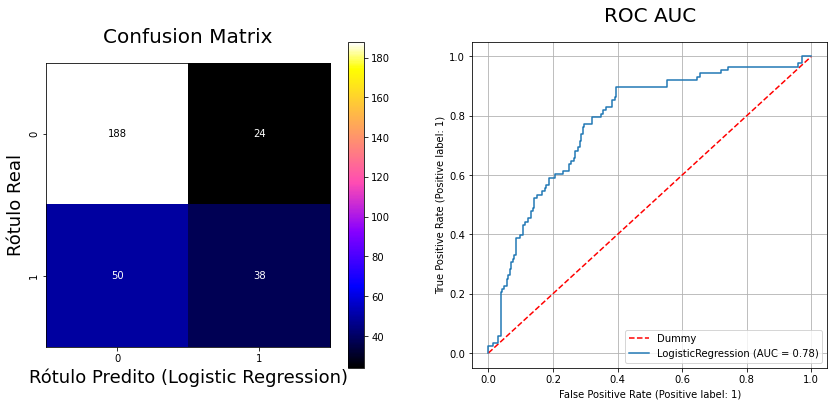

,0,1,accuracy,macro avg,weighted avg
precision,0.789916,0.612903,0.753333,0.701410,0.737992
recall,0.886792,0.431818,0.753333,0.659305,0.753333
f1-score,0.835556,0.506667,0.753333,0.671111,0.739081
support,212.000000,88.000000,0.753333,300.000000,300.000000


In [36]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(14,6)
ax2.set_title('ROC AUC', fontsize=20, pad=20)
ax2.plot([0,1],[0,1], '--', label='Dummy', color='red')
ax2.grid()
plot_roc_curve(logistic_regression, x_teste, y_teste, ax=ax2)



ax1.set_title('Confusion Matrix', fontsize=20, pad=20)
plot_confusion_matrix(logistic_regression, x_teste, y_teste, ax=ax1, cmap='gnuplot2',)
ax1.set_ylabel('Rótulo Real', fontsize=18)
ax1.set_xlabel('Rótulo Predito (Logistic Regression)', fontsize=18)
ax1.set_yticklabels(['0','1'], rotation=90, fontdict={'verticalalignment':'center'})
ax1.set_xticklabels(['0','1'])

plt.show()
display(classification_report_logistic.style.set_caption('Classification Report Logistic Regression'))

**Confussion Matrix**

Na diagonal principal da matriz de confusão temos os verdadeiros negativos (38) e os verdadeiros positivos (182), já na diagonal secundária é ilustrado os falsos negativos (52) e os falsos positivos (28).

Por exemplo, na primeira coluna temos as predições do modelo, quantas ele acertou efetivamente? Bom, foram 182 predições corretas dentre as 182+52 submetidas, logo a precisão é de $\frac{182}{182+52} = 0.7777$. Já na primeira linha da matriz temos os rótulos verdadeiros, então o recall desta classe será quantos acertamos (182) dividido pela quantidade de elementos reais nesta classe (182+28), isto é: $\frac{182}{182 + 28} = 0.8666$.

A precisão leva em conta quantas amostras foram fornecidas de um determinado rótulo e quantos foram os acertos do modelo, e a sensibilidade(recall) avalia quantas predições corretas foram feitas dada a quantidade de amostras daquele rótulo.

Outra métrica importante indicada no classification report é o `f1-score`. A métrica f1 é uma média harmônica da precisão e do recall: 

$$\text{f1-score} = 2\frac{\text{precisão}\times\text{recall}}{\text{precisão}+\text{recall}},$$

a média harmonica garante que o desempenho das métricas sejam homogêneos, isto é, se a precisão e a sensibilidade do modelo forem alta, o f1-score será alto, mas se a precisão for alta e o recall baixo, o f1-score será baixo. Essas métricas são todas indicadas no classification report.

> **A depender do tipo de negocio que se esta analisando**, é importante controlar a quantidade de falsos positivos ou falsos negativos, no caso de consessão de credito por exemplo, **conceder credito à um mal pagador pode gerar prejuizos** por outro lado, **negar credito à um bom pagador pode reduzir o próprio sistema de credito financeiro**, então é preciso ficar atento à essas duas métricas.

**Curva ROC**

O resultado foi relativamente bom, dado a curva ROC. A curva ROC leva em conta a **taxa de verdadeiros positivos (sensibilidade)** e também a **taxa de falsos positivos (especificidade)**, geralmente a curva ROC é importante para se calcular a àrea sob a curva, conhecida como AUC. Em outras palavras ela avalia o desempenho do modelo a partir dessas duas métricas classificar corretamente o rótulo da amostra isso porque **ela maximiza a taxa de verdadeiros positivos e minimiza a taxa de falsos positivos**

# Regras brasileiras



Como já foi dito anteriormente a base de dados utilizado se refere ao sistema de concessão de crédito para cidadãos Alemãos. O sistema brasileiro de análise de credito é um pouco diferente.

Todas as instituições financeiras devem fornecer os seus modelos de análise de credito ao Banco Central Brasileiro (BCB), e ele quem regulamenta e fiscaliza as instituições financeiras. Estas devem seguir uma série de exigências para que possam fornecer um serviço de crédito.

O Banco Central exige que algumas variáveis de natureza sensível não sejam utilizadas como critérios para aprovar ou não o crédito, por exemplo, não é permitido que instituições financeiras utilizem dados de origem social e étnica, condições de saúde, informações genéticas, orientação sexual, convicções políticas, religiosas e filosóficas, no Brasil.

É importante salientar que cada instituição financeira pode **decidir suas políticas de crédito mas não pode decidir seu modelo matemático de concessão de crédito**, essas atividades são fiscalizadas pelo banco central.

Agora, se levarmos em conta que nos nossos dados estamos considerando informações sensíveis, por exemplo, o sexo, devemos fazer algumas modificações na base de dados.


## Reajustando variáveis

### situação civil

A variável `personal_status_sex` indica:

In [37]:
mapas['mapa_personal_status_sex']

{'male : single': 0,
 'female : divorced/separated/married': 1,
 'male : divorced/separated': 2,
 'male : married/widowed': 3}

Vou transformar essas variáveis em um dummy:

In [38]:
personal_status_sex = pd.get_dummies(credit_score['personal_status_sex'])
personal_status_sex.head()

,female : divorced/separated/married,male : divorced/separated,male : married/widowed,male : single
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [39]:
personal_status_sex.sum()

female : divorced/separated/married    310
male : divorced/separated               50
male : married/widowed                  92
male : single                          548
dtype: int64

Note que as informações estão completamente desproporcionais, para deixar equilibrado eu vou juntar as categorias `divorced/separated` e `married/widowed` em uma nova variável chamada `civil_status`, que irá ter o total de 310+50+92 = 452 registros.

In [40]:
personal_civi_status = personal_status_sex[personal_status_sex.columns[:-1]]
personal_civi_status.head()

,female : divorced/separated/married,male : divorced/separated,male : married/widowed
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0


O que eu vou fazer aqui é basicamente transpor o dataframe `personal_civil_status` e aplicar a função `.any()` que retorna `True` caso a lista contenha algum elemento e `False` caso não tenha; por fim aplicamos o `.sum()` para somar todos os elementos de cada registro. Com isso teremos 1 para as observações que tiverem algum tipo de relação civil e 0 para quem não tem. Aliás, o fato do dataframe `personal_civil_status` só ter informações referente a relacionamentos, ao realizar o `.any().sum()` e o resultado for zero, se tem garantia que a observação se trata de uma pessoa solteira.

In [41]:
civil_status = personal_civi_status.T.apply(lambda x: x.any().sum())
civil_status.value_counts()

0    548
1    452
dtype: int64

Desta forma além de deixarmos a categoria mais balanceada, temos uma anonimização do sexo da amostra.

In [42]:
credit_score['civil_status'] = civil_status

Agora podemos comparar a variavel `civil_status` com a `personal_status_sex`:

In [43]:
credit_score[['personal_status_sex', 'civil_status']].head(20)

,personal_status_sex,civil_status
0,male : single,0
1,female : divorced/separated/married,1
2,male : single,0
3,male : single,0
4,male : single,0
5,male : single,0
6,male : single,0
7,male : single,0
8,male : divorced/separated,1
9,male : married/widowed,1


## faixa etaria

Aqui eu vou criar grupos de faixa etaria, dentro da variável `age` se tem a idade real da pessoa, por uma questão de sensibilidade vamos categorizar as idades:

* Categoria 1: 18 à 30 anos
* Categoria 2: 31 à 40 anos
* Categoria 3: 41 à 50 anos
* Categoria 4: 51 à 60 anos
* Categoria 5: 61 à 70 anos
* Categoria 6: 71 à 80 anos

Isso pode ser feito através da funçao `.cut()` do pandas:

> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

In [44]:
age_range = pd.cut(credit_score.age, bins=[18,30,40,50,60,70,80], labels=[1, 2, 3, 4, 5, 6])
age_range

0      5
1      1
2      3
3      3
4      4
      ..
995    2
996    2
997    2
998    1
999    1
Name: age, Length: 1000, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

Note que o resultado é uma variável categorica, tal que: `Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]`

Vamos adicionar esta variável ao cŕedit score, ao passo que removemos a variável `age`

In [45]:
credit_score['age_range'] = age_range

### Prazo em meses

também vou categorizar o prazo do crédito em meses, indicado pela variável `duration_in_mounth`

* categoria 1: 1 à 12 meses
* categoria 2: 13 à 24 meses
* categoria 3: 25 à 36 meses
* categoria 4: 37 à 48 meses
* categoria 5: 49 à 60 meses
* cateoriga 6: 61 à 72 meses

In [46]:
credit_score['credit_term_range']  = pd.cut(credit_score.duration_in_month, bins=[1, 12, 24, 36, 48, 60, 72], labels=[1,2,3,4,5,6])
credit_score.credit_term_range

0      1
1      4
2      1
3      4
4      2
      ..
995    1
996    3
997    1
998    4
999    4
Name: credit_term_range, Length: 1000, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

### Quantidade de credito

Também irei categorizar o valor do pedido de emprestimo a cada 1000 euros indicado na variável `credit_amount`, vou utilizar o numpy para criar a descrição:

In [47]:
credit_score.credit_amount.head()

0    1169
1    5951
2    2096
3    7882
4    4870
Name: credit_amount, dtype: int64

In [48]:
intervalo = np.arange(1, 21000, 1000)
indice = 1
categorias, reparticoes = [], []

for i in range(len(intervalo) - 1):
    print(f'Categoria {indice} : {intervalo[indice - 1]} - {intervalo[indice] - 1}')
    categorias.append(indice)
    reparticoes.insert(indice, intervalo[indice] - 1)
    indice += 1
reparticoes.insert(0,1)

print(f'\n\nCategorias: {categorias}\nReparticoes: {reparticoes}')

Categoria 1 : 1 - 1000
Categoria 2 : 1001 - 2000
Categoria 3 : 2001 - 3000
Categoria 4 : 3001 - 4000
Categoria 5 : 4001 - 5000
Categoria 6 : 5001 - 6000
Categoria 7 : 6001 - 7000
Categoria 8 : 7001 - 8000
Categoria 9 : 8001 - 9000
Categoria 10 : 9001 - 10000
Categoria 11 : 10001 - 11000
Categoria 12 : 11001 - 12000
Categoria 13 : 12001 - 13000
Categoria 14 : 13001 - 14000
Categoria 15 : 14001 - 15000
Categoria 16 : 15001 - 16000
Categoria 17 : 16001 - 17000
Categoria 18 : 17001 - 18000
Categoria 19 : 18001 - 19000
Categoria 20 : 19001 - 20000


Categorias: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Reparticoes: [1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]


Agora aplicamos o `pd.cut()` passando a variável `credit_amount`, `reparticoes` e `categorias`

In [49]:
credit_score['credit_amount_range'] = pd.cut(credit_score.credit_amount,
                                             bins=reparticoes, labels=categorias)
credit_score['credit_amount_range'].value_counts()

2     316
3     188
4     134
1     116
5      58
7      44
6      39
8      35
9      17
10     13
11     11
12      8
13      8
15      7
16      4
14      1
19      1
17      0
18      0
20      0
Name: credit_amount_range, dtype: int64

### Removendo as variáveis

Agora vamos remover as variaveis que utilizamos para criar as categorias `civil_status`, `age_range`, `credit_term_range` e `credit_amount_range`:

In [50]:
credit_score = credit_score.drop(columns = 'personal_status_sex')
credit_score = credit_score.drop(columns = 'age')
credit_score = credit_score.drop(columns = 'duration_in_month')
credit_score = credit_score.drop(columns = 'credit_amount')



### Separando dados novamente

Agora é preciso novamente separar os dados em variáveis independentes e dependentes:

In [51]:
credit_score.columns

Index(['default', 'account_check_status', 'credit_history', 'purpose',
       'savings', 'present_emp_since', 'installment_as_income_perc',
       'other_debtors', 'present_res_since', 'property',
       'other_installment_plans', 'housing', 'credits_this_bank', 'job',
       'people_under_maintenance', 'telephone', 'foreign_worker',
       'civil_status', 'age_range', 'credit_term_range',
       'credit_amount_range'],
      dtype='object')

In [52]:
y = credit_score['default']
x = credit_score.drop(columns='default')

Agora precisamos transformar novamente as variáveis do tipo object em numéricas:

In [53]:
variaveis_object = x.select_dtypes('object')

In [54]:
mapas = {}
for variavel in variaveis_object:
    rotulo = x[variavel].unique()
    
    # cria o mapa para a variável
    mapa = {}
    for indice, rotulo in enumerate(rotulo):
        mapa[rotulo] = indice
    
    mapas[f'mapa_{variavel}'] = mapa
    x[variavel] = x[variavel].map(mapa)

In [55]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   account_check_status        1000 non-null   int64   
 1   credit_history              1000 non-null   int64   
 2   purpose                     1000 non-null   int64   
 3   savings                     1000 non-null   int64   
 4   present_emp_since           1000 non-null   int64   
 5   installment_as_income_perc  1000 non-null   int64   
 6   other_debtors               1000 non-null   int64   
 7   present_res_since           1000 non-null   int64   
 8   property                    1000 non-null   int64   
 9   other_installment_plans     1000 non-null   int64   
 10  housing                     1000 non-null   int64   
 11  credits_this_bank           1000 non-null   int64   
 12  job                         1000 non-null   int64   
 13  people_under_mainte

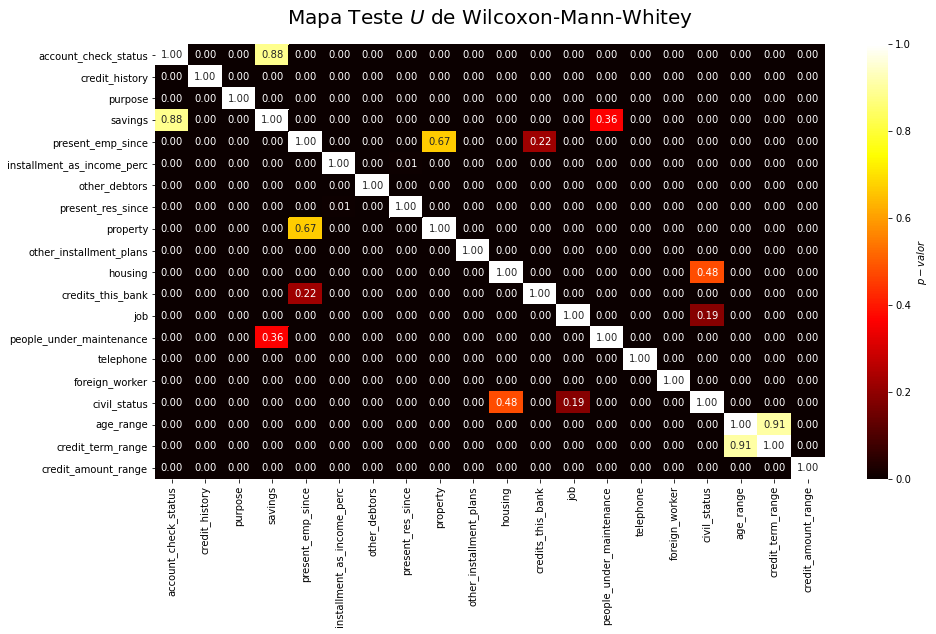

In [56]:
teste_U_wilcoxon, ax_matriz_wilcoxon = aplica_teste_wilcoxon(x, exibe_mapa=True)


# Automatizando treino, teste e avaliação

Vou criar uma função que vai receber as features (variaveis independentes) e o target (variavel dependente), realizar o processo de separação em treino e teste, ajustar o modelo e testar e retornar as métricas de avaliação: confusion matriz, ROC e AUC Score, e o classifiation report.

In [82]:
def executa_epoca(x, y, estimador, random_state = semente, exibe_resultados=True):
    # Split dos dados
    x_treino, x_teste, y_treino, y_teste = train_test_split(x, y,test_size = 0.3, random_state = semente)

    # Ajustando modelo
    estimador.fit(x_treino, y_treino)
    
    # Realizando predição
    y_predito = estimador.predict(x_teste)
    
    # Métricas de avaliação
    classification_report_estimador = classification_report(y_teste, y_predito, output_dict=True)
    classification_report_estimador = pd.DataFrame(classification_report_estimador)
    
    if exibe_resultados:        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(14,6)
        ax2.set_title('ROC AUC', fontsize=20, pad=20)
        ax2.plot([0,1],[0,1], '--', label='Dummy', color='red')
        ax2.grid()
        plot_roc_curve(estimador, x_teste, y_teste, ax=ax2)



        ax1.set_title('Confusion Matrix', fontsize=20, pad=20)
        plot_confusion_matrix(estimador, x_teste, y_teste, ax=ax1, cmap='gnuplot2',)
        ax1.set_ylabel('Rótulo Real', fontsize=18)
        ax1.set_xlabel(f'Rótulo Predito {str(estimador).split("(")[0]}', fontsize=18)
        ax1.set_yticklabels(['0','1'], rotation=90, fontdict={'verticalalignment':'center'})
        ax1.set_xticklabels(['0','1'])

        plt.show()
        #print(f'Classification Report {str(estimador).split("(")[0]}')
        display(classification_report_estimador.style.set_caption(f'Classification Report {str(estimador).split("(")[0]}'))
        
        return estimador, classification_report_estimador
    else:
        return estimador, classification_report_estimador
    

Bom, agora com essa função `executa_epoca` conseguimos definir um estimador e realizar um processo de treino/teste e avaliação:

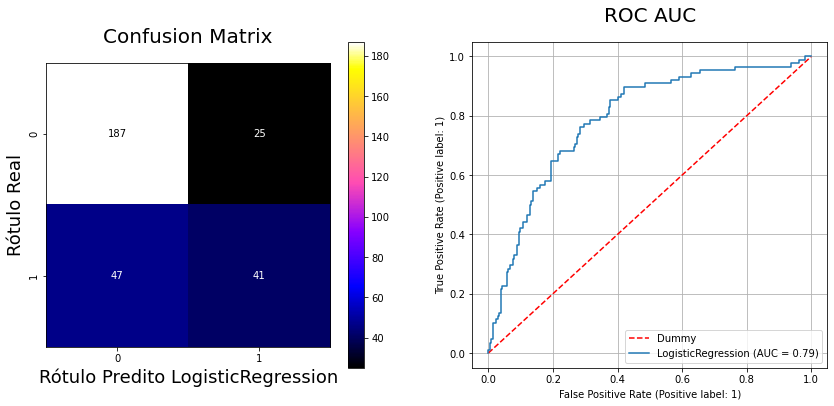

,0,1,accuracy,macro avg,weighted avg
precision,0.799145,0.621212,0.760000,0.710179,0.746952
recall,0.882075,0.465909,0.760000,0.673992,0.760000
f1-score,0.838565,0.532468,0.760000,0.685516,0.748776
support,212.000000,88.000000,0.760000,300.000000,300.000000


In [83]:
logit = LogisticRegression(max_iter=55000)
logit, classification_report_logit = executa_epoca(x,y,logit, semente)

Aliás podemos definir outros estimadores, vamos testar os três estimadores:


* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression)

* [Naive Bayes](https://scikit-learn.org/stable/modules/classes.html?highlight=naive#module-sklearn.naive_bayes)

* [Support Vector Machine: Linear (LinearSVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

* [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier)

* [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)


## Naive Bayes Categorical

In [97]:
from sklearn.naive_bayes import CategoricalNB
categorical_naive_bayes = CategoricalNB(min_categories=1)

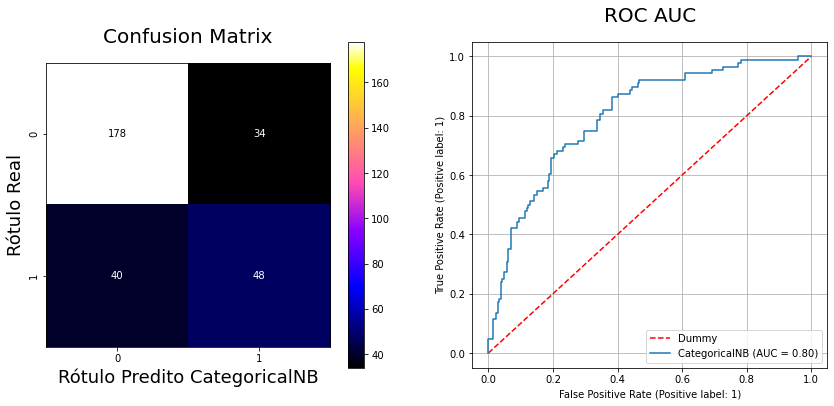

,0,1,accuracy,macro avg,weighted avg
precision,0.816514,0.585366,0.753333,0.700940,0.748710
recall,0.839623,0.545455,0.753333,0.692539,0.753333
f1-score,0.827907,0.564706,0.753333,0.696306,0.750701
support,212.000000,88.000000,0.753333,300.000000,300.000000


In [98]:
categorical_naive_bayes, classification_report_naive_bayes = executa_epoca(x, y,
                                                                           categorical_naive_bayes,
                                                                           semente)

## Linear SVC

In [61]:
from sklearn.svm import LinearSVC

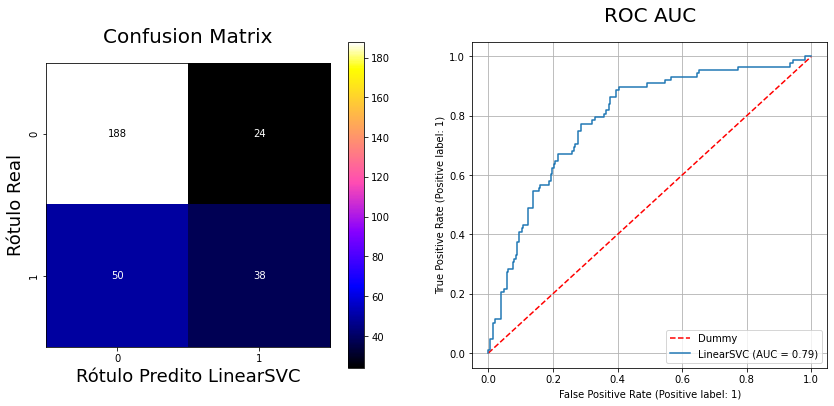

,0,1,accuracy,macro avg,weighted avg
precision,0.789916,0.612903,0.753333,0.701410,0.737992
recall,0.886792,0.431818,0.753333,0.659305,0.753333
f1-score,0.835556,0.506667,0.753333,0.671111,0.739081
support,212.000000,88.000000,0.753333,300.000000,300.000000


In [62]:
linear_svc = LinearSVC(max_iter=55000)

linear_svc, classification_report_svc = executa_epoca(x, y, linear_svc, semente)

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
random_forest = RandomForestClassifier(random_state = semente)

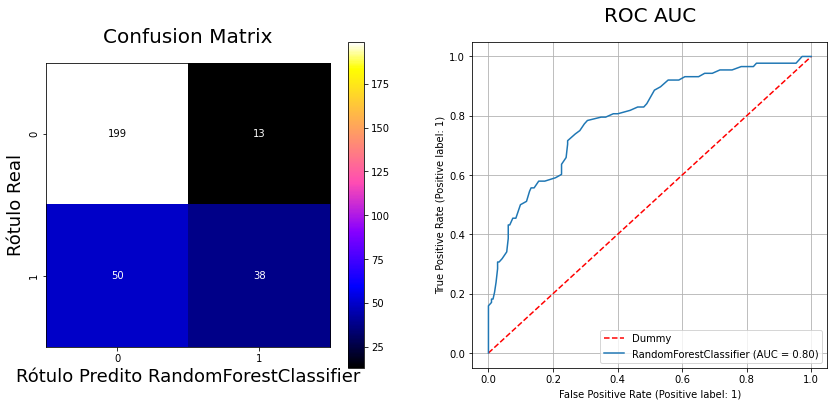

,0,1,accuracy,macro avg,weighted avg
precision,0.799197,0.745098,0.790000,0.772147,0.783328
recall,0.938679,0.431818,0.790000,0.685249,0.790000
f1-score,0.863341,0.546763,0.790000,0.705052,0.770478
support,212.000000,88.000000,0.790000,300.000000,300.000000


In [65]:
random_forest, classification_report_random_forest = executa_epoca(x, y, random_forest, semente)

## Decision Tree Classifier

In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
decision_tree = DecisionTreeClassifier(random_state=semente)

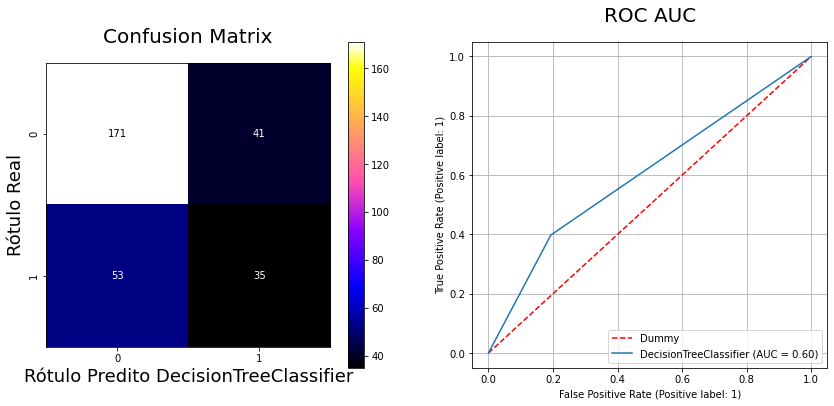

,0,1,accuracy,macro avg,weighted avg
precision,0.763393,0.460526,0.686667,0.611960,0.674552
recall,0.806604,0.397727,0.686667,0.602166,0.686667
f1-score,0.784404,0.426829,0.686667,0.605616,0.679515
support,212.000000,88.000000,0.686667,300.000000,300.000000


In [68]:
decision_tree, classification_report_decision_tree = executa_epoca(x, y, decision_tree, semente)

# Avaliando redução de variáveis


Ao construir novas variaveis verifiquei que houve uma variação nas métricas de qualidade, então para cada modelo eu vou selecionar as melhores variáveis através do `f_classif`, um teste de hipoteses F. 

In [69]:
# definindo modelos
modelos = {
    'logistic_regression' : logistic_regression,
    'categorical_naive_bayes': categorical_naive_bayes,
    'random_forest':random_forest,
    'decision_tree_classifier':decision_tree,
    'linear_svc':linear_svc
}

In [70]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif,chi2, mutual_info_classif

# dicionario onde serão armazenadas as métricas
metricas_modelos = {}

for nome_modelo, modelo in modelos.items():
    avaliacao_f1 = pd.DataFrame({}, columns = list(range(2,20)))
    avaliacao_precision = pd.DataFrame({}, columns = list(range(2,20)))
    avaliacao_recall = pd.DataFrame({}, columns = list(range(2,20)))

    for k in range(2,21):
        X_k_best = SelectKBest(f_classif, k=k).fit_transform(x, y)
        _, classification_report_modelo = executa_epoca(X_k_best, y,modelo,semente,
                                                        exibe_resultados=False)

        avaliacao_f1[k] = classification_report_modelo.T['f1-score'].iloc[:2]
        avaliacao_precision[k]  = classification_report_modelo.T['precision'].iloc[:2]
        avaliacao_recall[k] = classification_report_modelo.T['recall'].iloc[:2]

    avaliacao_f1 = avaliacao_f1.rename_axis(columns='k_variaveis').T
    avaliacao_precision = avaliacao_precision.rename_axis(columns='k_variaveis').T
    avaliacao_recall = avaliacao_recall.rename_axis(columns='k_variaveis').T
    
    metricas_modelos[nome_modelo] = pd.concat({'precision' : avaliacao_precision.T,
                                               'recall': avaliacao_recall.T, 
                                               'f1-score': avaliacao_f1.T}, names=['Metricas']).T.round(4)

Agora Basta olhar na variavel `metricas_modelos` 

In [71]:
metricas_modelos.keys()

dict_keys(['logistic_regression', 'categorical_naive_bayes', 'random_forest', 'decision_tree_classifier', 'linear_svc'])

Por exemplo, se queremos ver o desempenho das métricas precision, recall e f1 do modelo random forest, basta, chama-lo:

In [72]:
metricas_modelos['random_forest'].head()

Metricas    precision          recall         f1-score        
                    0       1       0       1        0       1
k_variaveis                                                   
2              0.7973  0.5513  0.8349  0.4886   0.8157  0.5181
3              0.7924  0.6094  0.8821  0.4432   0.8348  0.5132
4              0.7821  0.5606  0.8632  0.4205   0.8206  0.4805
5              0.7623  0.5357  0.8774  0.3409   0.8158  0.4167
6              0.7652  0.5660  0.8915  0.3409   0.8235  0.4255

Podemos ordenar ainda utilizando o `sort_values()` mas com a condição de passar o primeiro e segundo índice numa tupla:

In [73]:
metricas_modelos['random_forest'].sort_values(by = ('recall','1'), ascending=False).head()

Metricas    precision          recall         f1-score        
                    0       1       0       1        0       1
k_variaveis                                                   
2              0.7973  0.5513  0.8349  0.4886   0.8157  0.5181
10             0.8042  0.6833  0.9104  0.4659   0.8540  0.5541
11             0.8033  0.6721  0.9057  0.4659   0.8514  0.5503
12             0.8025  0.7018  0.9198  0.4545   0.8571  0.5517
15             0.8041  0.7273  0.9292  0.4545   0.8621  0.5594

Podemos verificar que o melhor recall da categoria 1 é com 2 variaveis. Podemos verificar qual a melhor métrica de recall do naive bayes, que é o modelo que teve um AUC: 0.8

In [74]:
metricas_modelos['categorical_naive_bayes'].sort_values(by=('recall','1'), ascending=False).head()

Metricas    precision          recall         f1-score        
                    0       1       0       1        0       1
k_variaveis                                                   
18             0.8233  0.5882  0.8349  0.5682   0.8290  0.5780
13             0.8251  0.6364  0.8679  0.5568   0.8460  0.5939
20             0.8165  0.5854  0.8396  0.5455   0.8279  0.5647
19             0.8165  0.5854  0.8396  0.5455   0.8279  0.5647
15             0.8230  0.6486  0.8774  0.5455   0.8493  0.5926

> Note acima que temos os 5 maiores desempenhos do Categorical Naive-Bayes. Por exemplo, com 18 variáveis o recall da categoria `1` foi de 0.5682 (56.82%). Apesar de não ser o maior f-score na categoria `1` tem o melhor recall, isto é, aqueles tomadores que são mal pagadores são melhores classificados pelo modelo, ao passo que os que realmente são bons pagadores tem um recall de 83.49%.


Para o Logistic Regression teremos um recall 

In [75]:
metricas_modelos['logistic_regression'].sort_values(by=('recall','1'), ascending=False).head()

Metricas    precision          recall         f1-score        
                    0       1       0       1        0       1
k_variaveis                                                   
16             0.8043  0.6462  0.8915  0.4773   0.8456  0.5490
15             0.8034  0.6364  0.8868  0.4773   0.8430  0.5455
20             0.7991  0.6212  0.8821  0.4659   0.8386  0.5325
17             0.8000  0.6308  0.8868  0.4659   0.8412  0.5359
19             0.7966  0.6250  0.8868  0.4545   0.8393  0.5263

Podemos verificar que o melhor recall no modelo Logistic Regression da classe 1 é em torno de 47.73%. Um pouco pior em relação ao Naive Bayes.

# Modelo Aplicado na base inteira:

Dado que escolhemos o modelo Categorical Naive Bayes precisamos treina-lo em todos os dados e disponibiliza-lo

In [99]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.feature_selection import f_classif,chi2, mutual_info_classif

# Instanciando modelo
categorical_naive_bayes = CategoricalNB(min_categories=1)

# selecionando a feature
X = SelectKBest(f_classif, k=18).fit_transform(x, y)

# treinando modelo
categorical_naive_bayes = categorical_naive_bayes.fit(X,y)

In [100]:
categorical_naive_bayes

CategoricalNB(min_categories=1)

# Conclusão

Tendo em vista que desejamos um modelo de credit score mais acertivo o mais indicado é utilizar o categorical naive-bayes, pois apesar de perdemos um pouco na precisão com relação aos outro modelos (Logisitc Regression por exemplo), o recall do modelo Naive Bayes esta com mais de 56% no acerto da classe `1`.


# Referências

> [Bancos de dados no Brasil: uma análise do sistema credit scoring à luz da LEI N. 13.709/2018 (LGPD) ](https://revistaeletronica.pge.rj.gov.br/pge/article/view/99)

> [LEI N.º 12.414, DE 9 DE JUNHO DE 2011.](https://www.planalto.gov.br/ccivil_03/_Ato2011-2014/2011/Lei/L12414.htm) Disciplina a formação e consulta a bancos de dados com informações de adimplemento, de pessoas naturais ou de pessoas jurídicas, para formação de histórico de crédito.
